In [1]:
%install-location $cwd/swift-install
%install '.package(path: "$cwd/swiftai")' SwiftAI

Installing packages:
	.package(path: "/home/mlk/swift/swiftai")
		SwiftAI
With SwiftPM flags: []
Working in: /tmp/tmpbj7341ko/swift-install
/home/mlk/swift/usr/bin/swift: /home/mlk/anaconda3/envs/fai/lib/libuuid.so.1: no version information available (required by /home/mlk/swift/usr/bin/swift)
/home/mlk/swift/usr/bin/swift: /home/mlk/anaconda3/envs/fai/lib/libuuid.so.1: no version information available (required by /home/mlk/swift/usr/bin/swift)
/home/mlk/swift/usr/bin/swift: /home/mlk/anaconda3/envs/fai/lib/libuuid.so.1: no version information available (required by /home/mlk/swift/usr/bin/swift)
/home/mlk/swift/usr/bin/swift: /home/mlk/anaconda3/envs/fai/lib/libuuid.so.1: no version information available (required by /home/mlk/swift/usr/bin/swift)
/home/mlk/swift/usr/bin/swiftc: /home/mlk/anaconda3/envs/fai/lib/libuuid.so.1: no version information available (required by /home/mlk/swift/usr/bin/swiftc)
/home/mlk/swift/usr/bin/swiftc: /home/mlk/anaconda3/envs/fai/lib/libuuid.so.1: no v

In [2]:
import SwiftAI
import TensorFlow
import Python
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")
let plt = Python.import("matplotlib.pyplot")
let np = Python.import("numpy")
import Foundation
import Just
import Path

In [3]:
let d = mnistDataBunch(path: Path.home/"swift", flat: true, bs: 256)

2019-11-28 02:12:00.840369: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 188160000 exceeds 10% of system memory.
2019-11-28 02:12:00.939275: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX
2019-11-28 02:12:00.993645: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2019-11-28 02:12:00.996956: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-11-28 02:12:00.997372: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 970 major: 5 minor: 2 memoryClockRate(GHz): 1.253
pciBusID: 0000:01:00.0
2019-11-28 02:12:01.044772: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened

In [4]:
d.train.ds.first(where: { _ in true })!.xb.shape

▿ [256, 784]
  ▿ dimensions : 2 elements
    - 0 : 256
    - 1 : 784


In [5]:
//MLP model with 2 hidden layers
public struct MyModel: Layer {
    public var hidden1: FADense<Float>
    public var hidden2: FADense<Float>
    public var out:     FADense<Float>
    
    public init(nIn: Int, nHid: Int, nOut: Int){
        hidden1 = FADense(nIn, nHid, activation: relu)
        hidden2 = FADense(nHid, nHid, activation: relu)
        out =     FADense(nHid, nOut)
    }
    
    @differentiable
    public func callAsFunction(_ input: TF) -> TF {
        return out(hidden2(hidden1(input)))
    }
}


In [6]:
func modelInit() -> MyModel { return MyModel(nIn: 784,nHid: 512, nOut: 10) }

In [7]:
// Source: http://cs231n.github.io/neural-networks-3/#sgd

public extension StateKeys {
    static let prevGrad = "previousAverageGrad"
}

public struct PreviousAverageGrad: StatDelegate {
    public var defaultHPs: [String:Float] { return [:] }
    public var name: String { return StateKeys.prevGrad }
    public func update(_ state: inout [String: TF], p: TF, 𝛁p: TF, hps: inout [String:Float]) {
        state[StateKeys.prevGrad]! = state[StateKeys.avgGrad]!
    }
}

public struct AvgGrad: StatDelegate {
    public var defaultHPs: [String: Float] { return [HyperParams.mom: 0.9] }
    public let dampened: Bool
    public init(dampened: Bool = false) { self.dampened = dampened }
    public var name: String { return StateKeys.avgGrad }
    public func update(_ state: inout [String: TF], p: TF, 𝛁p: TF, hps: inout [String:Float]) {
        state[StateKeys.avgGrad]! *= hps[HyperParams.mom]!
        hps[HyperParams.momDamp] = 1.0 - (dampened ? hps[HyperParams.mom]! : 0.0)
        state[StateKeys.avgGrad]! -= hps[HyperParams.lr]! * 𝛁p
    }
}

public struct NesterovStep: StepDelegate {
    public var defaultHPs: [String: Float] { return [HyperParams.mom: 0.9]}
    public init() {}
    public func update(_ p: inout TF, 𝛁p: inout TF, 
                       state: [String : TF], 
                       hps: inout [String : Float]){
        p += -hps[HyperParams.mom]! * state[StateKeys.prevGrad]! + ( 1 + hps[HyperParams.mom]!) * state[StateKeys.avgGrad]!
    }
}


In [8]:
public struct L1: StepDelegate {
    public var defaultHPs: [String: Float] { return [HyperParams.wd: 0.02] }
    public init() {}
    public func update(_ p: inout TF, 𝛁p: inout TF, state: [String:TF], hps: inout [String:Float]) {
        𝛁p += hps[HyperParams.wd]! * abs(p).sum()
    }
}

public struct L2: StepDelegate {
    public var defaultHPs: [String: Float] { return [HyperParams.wd: 0.02] }
    public init() {}
    public func update(_ p: inout TF, 𝛁p: inout TF, state: [String:TF], hps: inout [String:Float]) {
        𝛁p += hps[HyperParams.wd]! * p
    }
}

# MLP 1 with SGD

In [9]:
func sgd(_ model: MyModel) -> StatefulOptimizer<MyModel> {
    return StatefulOptimizer(for: model, 
                             steppers: [SGDStep()], 
                             stats: [], 
                             hps: [HyperParams.lr: 0.01])
}

let learner_sgd = Learner(
                    data: d, 
                    lossFunc: crossEntropy, 
                    optFunc: sgd, 
                    modelInit: modelInit)

let recorder_sgd = learner_sgd.makeDefaultDelegates(metrics: [accuracy])
learner_sgd.addDelegates([learner_sgd.makeNormalize(mean: mnistStats.mean, std: mnistStats.std)])

In [10]:
try! learner_sgd.fit(25)

2019-11-28 02:12:21.599171: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
Epoch 0: Train: [0.8256915, 0.79545] , Valid:[0.415817, 0.8915]                
Epoch 1: Train: [0.37166104, 0.89603335] , Valid:[0.31605, 0.9107]             
Epoch 2: Train: [0.30614528, 0.91223335] , Valid:[0.27644867, 0.9211]          
Epoch 3: Train: [0.27182266, 0.9220167] , Valid:[0.2513207, 0.9284]            
Epoch 4: Train: [0.24797574, 0.92885] , Valid:[0.23649853, 0.934]              
Epoch 5: Train: [0.22923721, 0.93485] , Valid:[0.21771026, 0.938]              
Epoch 6: Train: [0.21408293, 0.9392167] , Valid:[0.20800832, 0.9408]           
Epoch 7: Train: [0.20094267, 0.94265] , Valid:[0.19508834, 0.9453]             
Epoch 8: Train: [0.18943697, 0.94671667] , Valid:[0.18710364, 0.9453]          
Epoch 9: Train: [0.17933485, 0.9494] , Valid:[0.179408, 0.9488]                 
Epoch 10: Train: [0.17027889, 0.9523] , Valid:[0.1700

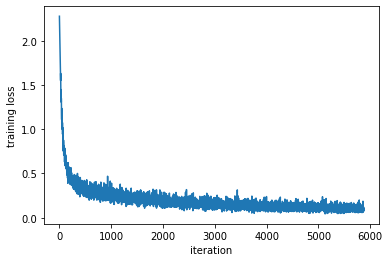

In [11]:
recorder_sgd.plotLosses()

# MLP 2 with  Nesterov

In [12]:
func sgdnest_opt(_ model: MyModel) -> StatefulOptimizer<MyModel> {
    return StatefulOptimizer(for: model, 
                             steppers: [NesterovStep()], 
                             stats: [PreviousAverageGrad(),AvgGrad()], 
                             hps: [HyperParams.lr: 0.01])
}

let learner_nest = Learner(
                    data: d, 
                    lossFunc: crossEntropy, 
                    optFunc: sgdnest_opt, 
                    modelInit: modelInit)

let recorder_nest = learner_nest.makeDefaultDelegates(metrics: [accuracy])
learner_nest.addDelegates([learner_nest.makeNormalize(mean: mnistStats.mean, std: mnistStats.std)])

In [13]:
try! learner_nest.fit(25)

Epoch 0: Train: [0.37716654, 0.89273334] , Valid:[0.1885278, 0.9448]           
Epoch 1: Train: [0.15657702, 0.9555167] , Valid:[0.13384983, 0.961]            
Epoch 2: Train: [0.112692945, 0.9676667] , Valid:[0.106644, 0.9681]            
Epoch 3: Train: [0.08751134, 0.9751] , Valid:[0.09143112, 0.9721]               
Epoch 4: Train: [0.07010606, 0.9802667] , Valid:[0.083709426, 0.9741]          
Epoch 5: Train: [0.05738024, 0.98361665] , Valid:[0.080383345, 0.9748]         
Epoch 6: Train: [0.047434423, 0.9871] , Valid:[0.07409422, 0.9761]             
Epoch 7: Train: [0.03931629, 0.9896333] , Valid:[0.07024234, 0.9783]           
Epoch 8: Train: [0.033178, 0.9914333] , Valid:[0.0698983, 0.9782]              
Epoch 9: Train: [0.027556213, 0.9934833] , Valid:[0.06833155, 0.978]           
Epoch 10: Train: [0.023074055, 0.99476665] , Valid:[0.065561906, 0.9789]       
Epoch 11: Train: [0.019379651, 0.9960833] , Valid:[0.06357886, 0.9806]          
Epoch 12: Train: [0.016619777, 0.99698

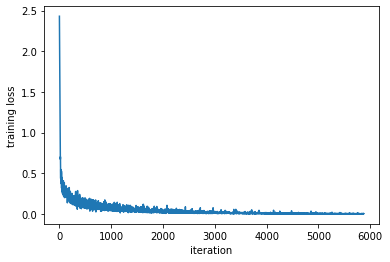

In [14]:
recorder_nest.plotLosses()

# MLP 3 with Nesterov and L1

In [15]:
//Optimizer with Nesterov step and L1 regularizer
func optFunc(_ model: MyModel) -> StatefulOptimizer<MyModel> {
    return StatefulOptimizer(for: model, 
                             steppers: [NesterovStep(), L1()], 
                             stats: [PreviousAverageGrad(),AvgGrad()], 
                             hps: [HyperParams.lr: 0.01, HyperParams.wd: 0.02])
}

let learner_nest_l1 = Learner(
                    data: d, 
                    lossFunc: crossEntropy, 
                    optFunc: optFunc, 
                    modelInit: modelInit)

let recorder_nest_l1 = learner_nest_l1.makeDefaultDelegates(metrics: [accuracy])
learner_nest_l1.addDelegates([learner_nest_l1.makeNormalize(mean: mnistStats.mean, std: mnistStats.std)])

In [16]:
learner_nest_l1.fit(25)

Epoch 0: Train: [0.3774865, 0.88916665] , Valid:[0.18716449, 0.9464]           
Epoch 1: Train: [0.15716884, 0.95456666] , Valid:[0.13205639, 0.9615]          
Epoch 2: Train: [0.11214672, 0.96783334] , Valid:[0.10581938, 0.9691]          
Epoch 3: Train: [0.08615211, 0.9755] , Valid:[0.09358374, 0.9724]              
Epoch 4: Train: [0.06913786, 0.9804] , Valid:[0.08863073, 0.9733]              
Epoch 5: Train: [0.056432303, 0.98448336] , Valid:[0.07809271, 0.9754]         
Epoch 6: Train: [0.046686105, 0.98795] , Valid:[0.071859784, 0.9791]           
Epoch 7: Train: [0.039205965, 0.9893] , Valid:[0.06899601, 0.9793]             
Epoch 8: Train: [0.03257335, 0.99203336] , Valid:[0.06622624, 0.9804]          
Epoch 9: Train: [0.027250333, 0.99383336] , Valid:[0.06605431, 0.98]           
Epoch 10: Train: [0.022917334, 0.99518335] , Valid:[0.064234585, 0.9809]       
Epoch 11: Train: [0.01934382, 0.9963833] , Valid:[0.064103246, 0.9808]         
Epoch 12: Train: [0.016439844, 0.9972] ,

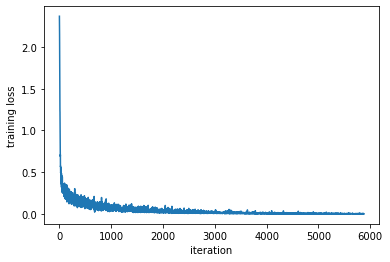

In [17]:
recorder_nest_l1.plotLosses()

# MLP 4 with Nesterov and L2

In [18]:
func SGD_nest_L2(_ model: MyModel) -> StatefulOptimizer<MyModel> {
    return StatefulOptimizer(for: model, 
                             steppers: [NesterovStep()], 
                             stats: [PreviousAverageGrad(),AvgGrad()], 
                             hps: [HyperParams.lr: 0.01, HyperParams.wd: 0.02])
}

let learner_nest_l2 = Learner(
                    data: d, 
                    lossFunc: crossEntropy, 
                    optFunc: SGD_nest_L2, 
                    modelInit: modelInit)

let recorder_nest_l2 = learner_nest_l2.makeDefaultDelegates(metrics: [accuracy])
learner_nest_l2.addDelegates([learner_nest_l2.makeNormalize(mean: mnistStats.mean, std: mnistStats.std)])

In [19]:
learner_nest_l2.fit(25)

Epoch 0: Train: [0.37558585, 0.8903667] , Valid:[0.18743776, 0.9449]           
Epoch 1: Train: [0.15990591, 0.95421666] , Valid:[0.13640921, 0.9611]          
Epoch 2: Train: [0.11563746, 0.96655] , Valid:[0.10714391, 0.9693]             
Epoch 3: Train: [0.08871549, 0.97473335] , Valid:[0.093572386, 0.9721]         
Epoch 4: Train: [0.07112986, 0.9802333] , Valid:[0.086341396, 0.9747]          
Epoch 5: Train: [0.05765195, 0.98406667] , Valid:[0.08065691, 0.9746]          
Epoch 6: Train: [0.047901385, 0.9870167] , Valid:[0.07207917, 0.978]            
Epoch 7: Train: [0.039714776, 0.98971665] , Valid:[0.068382286, 0.9787]        
Epoch 8: Train: [0.033252873, 0.99185] , Valid:[0.06737211, 0.9787]            
Epoch 9: Train: [0.028092675, 0.9931333] , Valid:[0.06660665, 0.9791]          
Epoch 10: Train: [0.023567246, 0.9949333] , Valid:[0.06740897, 0.979]          
Epoch 11: Train: [0.020226892, 0.99593335] , Valid:[0.0638515, 0.9796]         
Epoch 12: Train: [0.017063793, 0.996816

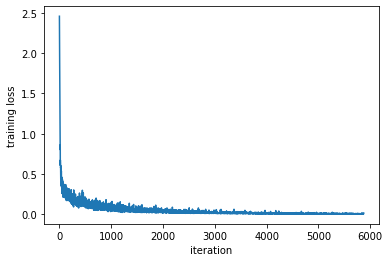

In [20]:
recorder_nest_l2.plotLosses()

In [21]:
let y = Array(0..<recorder_nest_l2.losses.count)
let sgd: Array<Float>     = recorder_sgd.losses.compactMap{$0.scalar}
let nest: Array<Float>    = recorder_nest.losses.compactMap{$0.scalar}
let nest_l1: Array<Float> = recorder_nest_l1.losses.compactMap{$0.scalar}
let nest_l2: Array<Float> = recorder_nest_l2.losses.compactMap{$0.scalar}


In [22]:
func smooth_curve(points:Array<Float>, factor:Float=0.9) -> Array<Float> {
    var smoothed_points: Array<Float> = Array()
    let x1 = points.first
    smoothed_points.append(x1!)
    var points_ = points.dropFirst()
    for point in points_{
            let previous = smoothed_points.last
            let smth = previous! * factor + point * (1 - factor)
            smoothed_points.append(smth)
    }
        
    return smoothed_points
}
    

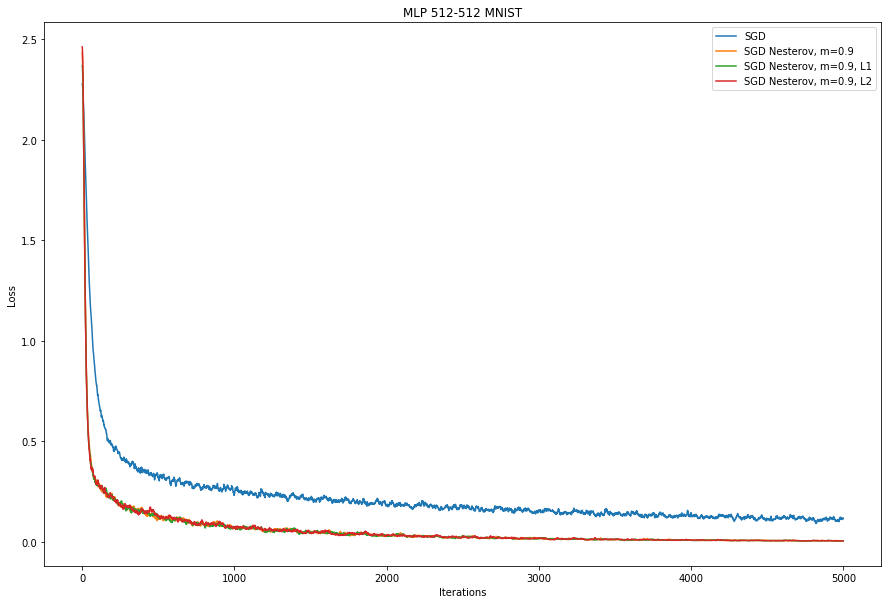

None


In [23]:
plt.figure(figsize: [15, 10])
let i = 0
let n = 5000
let y2 = Array(y[i..<n])
plt.plot(y2,smooth_curve(points: Array(sgd[i..<n])), label:"SGD")
plt.plot(y2,smooth_curve(points: Array(nest[i..<n])), label:"SGD Nesterov, m=0.9")
plt.plot(y2,smooth_curve(points: Array(nest_l1[i..<n])), label:"SGD Nesterov, m=0.9, L1")
plt.plot(y2,smooth_curve(points: Array(nest_l2[i..<n])), label:"SGD Nesterov, m=0.9, L2")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("MLP 512-512 MNIST")
plt.show()